[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)

# State Reducers 

## Review

We covered a few different ways to define LangGraph state schema, including `TypedDict`, `Pydantic`, or `Dataclasses`.
 
## Goals

Now, we're going to dive into reducers, which specify how state updates are performed on specific keys / channels in the state schema.

## Default overwriting state

Let's use a `TypedDict` as our state schema.

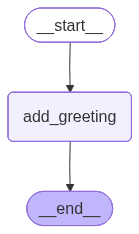

In [3]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    message: str

def add_greeting(state):
    print("---Adding Greeting---")
    return {"message": "Hello, " + state['message']}

# Build graph
builder = StateGraph(State)
builder.add_node("add_greeting", add_greeting)

# Logic
builder.add_edge(START, "add_greeting")
builder.add_edge("add_greeting", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({"message": "World!"})

---Adding Greeting---


{'message': 'Hello, World!'}

Let's look at the state update, `return {"foo": state['foo'] + 1}`.

As discussed before, by default LangGraph doesn't know the preferred way to update the state.
 
So, it will just overwrite the value of `foo` in `node_1`: 

```
return {"foo": state['foo'] + 1}
```
 
If we pass `{'foo': 1}` as input, the state returned from the graph is `{'foo': 2}`.

## Branching

Let's look at a case where our nodes branch.

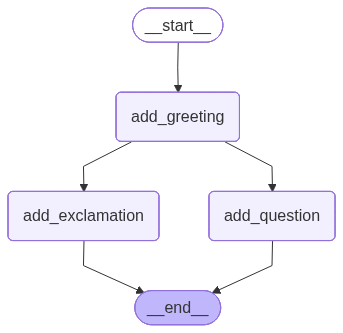

In [5]:
class State(TypedDict):
    message: str

def add_greeting(state):
    print("---Adding Greeting---")
    return {"message": "Hello, " + state['message']}

def add_exclamation(state):
    print("---Adding Exclamation---")
    return {"message": state['message'] + "!"}

def add_question(state):
    print("---Adding Question---")
    return {"message": state['message'] + "?"}

# Build graph
builder = StateGraph(State)
builder.add_node("add_greeting", add_greeting)
builder.add_node("add_exclamation", add_exclamation)
builder.add_node("add_question", add_question)

# Logic
builder.add_edge(START, "add_greeting")
builder.add_edge("add_greeting", "add_exclamation")
builder.add_edge("add_greeting", "add_question")
builder.add_edge("add_exclamation", END)
builder.add_edge("add_question", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"message": "World"})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Adding Greeting---
---Adding Exclamation---
---Adding Question---
InvalidUpdateError occurred: At key 'message': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


We see a problem! 

Node 1 branches to nodes 2 and 3.

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.

They both attempt to overwrite the state *within the same step*. 

This is ambiguous for the graph! Which state should it keep? 

## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function. 

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

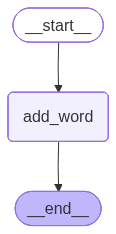

In [7]:
from operator import add
from typing import Annotated

class State(TypedDict):
    words: Annotated[list[str], add]

def add_word(state):
    print("---Adding Word---")
    return {"words": [state['words'][0] + " there"]}

# Build graph
builder = StateGraph(State)
builder.add_node("add_word", add_word)

# Logic
builder.add_edge(START, "add_word")
builder.add_edge("add_word", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"words": ["Hello"]})

---Adding Word---


{'words': ['Hello', 'Hello there']}

Now, our state key `foo` is a list.

This `operator.add` reducer function will append updates from each node to this list. 

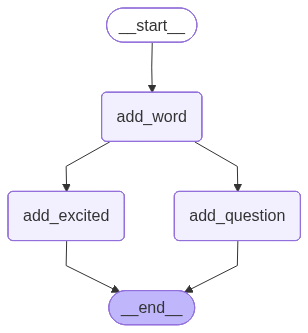

In [9]:
def add_word(state):
    print("---Adding Word---")
    return {"words": [state['words'][-1] + " there"]}

def add_excited(state):
    print("---Adding Excited---")
    return {"words": [state['words'][-1] + "!"]}

def add_question(state):
    print("---Adding Question---")
    return {"words": [state['words'][-1] + "?"]}

# Build graph
builder = StateGraph(State)
builder.add_node("add_word", add_word)
builder.add_node("add_excited", add_excited)
builder.add_node("add_question", add_question)

# Logic
builder.add_edge(START, "add_word")
builder.add_edge("add_word", "add_excited")
builder.add_edge("add_word", "add_question")
builder.add_edge("add_excited", END)
builder.add_edge("add_question", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

In [10]:
graph.invoke({"words": ["Hello"]})

---Adding Word---
---Adding Excited---
---Adding Question---


{'words': ['Hello', 'Hello there', 'Hello there!', 'Hello there?']}

Now, let's see what happens if we pass `None` to `foo`.

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`. 

In [11]:
try:
    graph.invoke({"words": None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

To address cases like this, [we can also define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state). 

For example, lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None`.

In [12]:
def combine_lists(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    words: Annotated[list[str], add]

class CustomReducerState(TypedDict):
    words: Annotated[list[str], combine_lists]

In `node_1`, we append the value 2.

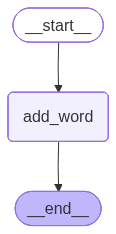

TypeError occurred: can only concatenate list (not "NoneType") to list


In [13]:
def add_word(state):
    print("---Adding Word---")
    return {"words": ["World"]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("add_word", add_word)

# Logic
builder.add_edge(START, "add_word")
builder.add_edge("add_word", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"words": None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Now, try with our custom reducer. We can see that no error is thrown.

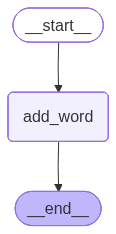

---Adding Word---
{'words': ['World']}


In [14]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("add_word", add_word)

# Logic
builder.add_edge(START, "add_word")
builder.add_edge("add_word", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"words": None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

In module 1, we showed how to use a built-in reducer, `add_messages`, to handle messages in state.

We also showed that [`MessagesState` is a useful shortcut if you want to work with messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate). 

* `MessagesState` has a built-in `messages` key 
* It also has a built-in `add_messages` reducer for this key

These two are equivalent. 

We'll use the `MessagesState` class via `from langgraph.graph import MessagesState` for brevity.


In [15]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Welcome!", name="Assistant"),
                    HumanMessage(content="Hi there!", name="User")
                   ]

# New message to add
new_message = AIMessage(content="How can I help you today?", name="Assistant")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Welcome!', additional_kwargs={}, response_metadata={}, name='Assistant', id='40111a89-c9e8-47fa-be1e-c139823ee333'),
 HumanMessage(content='Hi there!', additional_kwargs={}, response_metadata={}, name='User', id='ae37c658-f166-4a09-ae3d-ba4c052a710c'),
 AIMessage(content='How can I help you today?', additional_kwargs={}, response_metadata={}, name='Assistant', id='d382168b-21f3-4b05-a70e-16ea4190943b')]

Let's talk a bit more about usage of the `add_messages` reducer.

In [16]:
# Initial state
initial_messages = [AIMessage(content="Welcome!", name="Assistant", id="1"),
                    HumanMessage(content="Hi there!", name="User", id="2")
                   ]

# Updated message
updated_message = HumanMessage(content="Hello!", name="User", id="2")

# Test
add_messages(initial_messages , updated_message)

[AIMessage(content='Welcome!', additional_kwargs={}, response_metadata={}, name='Assistant', id='1'),
 HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, name='User', id='2')]

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

### Re-writing

Let's show some useful tricks when working with the `add_messages` reducer.

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

In [17]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Welcome!", name="Assistant", id="1")]
messages.append(HumanMessage("Hi!", name="User", id="2"))
messages.append(AIMessage("How can I help?", name="Assistant", id="3"))
messages.append(HumanMessage("Tell me about cats", name="User", id="4"))

# Messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


### Removal

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/). 

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

In [18]:
add_messages(messages , delete_messages)

[AIMessage(content='How can I help?', additional_kwargs={}, response_metadata={}, name='Assistant', id='3'),
 HumanMessage(content='Tell me about cats', additional_kwargs={}, response_metadata={}, name='User', id='4')]

We can see that mesage IDs 1 and 2, as noted in `delete_messages` are removed by the reducer.

We'll see this put into practice a bit later.